In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
from conquer import conquer
from hd_conquer import reg_conquer, val_conquer
import scipy.stats as spstat
import time

def check(x, tau):
    return np.mean(x*(tau-(x<0)))

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

## Model 1

Let $z=(z_1, \ldots, z_p)^T \sim N(0, \Sigma)$ with $\Sigma = (0.5^{|j-k|})_{1\leq j, k \leq p}$. Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ from the model $y_i =   \langle x_i, \beta^*  \rangle    + 0.7 x_{i1}  \varepsilon_i$, where $x_i = (x_{i1}, \ldots, x_{ip})^T \sim (\Phi(z_1), z_2, \ldots, z_p)^T$, $\varepsilon_i \sim N(0,1)$ are independent of $x_i$, and $\beta^* \in \mathbb R^p$ is sparse with $\beta^*_6 = \beta^*_{12} =\beta^*_{15} = \beta^*_{20} =1$.

Consider two quantile levels: $\tau=0.5$ and $\tau=0.7$. Note that the effect of $x_{i1}$ is only present for $\tau=0.7$.

In [2]:
n = 300
p = 1000
Mu, Sig = np.zeros(p), cov_generate(np.ones(p))
beta = np.zeros(p)
beta[5], beta[11], beta[14], beta[19] = 1, 1, 1, 1

B = 100
coef_err = np.zeros(shape=(B,3))
true_pos = np.zeros(shape=(B,3))
false_pos = np.zeros(shape=(B,3))

### Case 1: $\tau=0.5$.

In [3]:
tau = 0.5
true_beta = np.copy(beta)
true_beta[0] = 0.7*spstat.norm.ppf(tau)
true_set = np.where(abs(true_beta)>0)[0]

runtime = np.zeros(3)
for b in range(B):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    X[:,0] = spstat.norm.cdf(X[:,0])
    Y = X.dot(beta) + 0.7*X[:,0]*rgt.normal(0,1,size=n)

    reg_sqr = reg_conquer(X, Y, intercept=False)
    sim_lambda = np.quantile(reg_sqr.self_tuning(tau), 0.9)
    
    ## l1-penalized conquer (l1 conquer)
    tic = time.time()
    l1_beta, l1_fit = reg_sqr.l1(sim_lambda, tau)
    runtime[0] += time.time() - tic
    l1_s = sum(abs(l1_beta)>0)
    l1_select = np.where(abs(l1_beta)>0)[0]

    ## Iteratively reweighted l1-penalized conquer (IRW-l1 conquer)
    tic = time.time()
    irw_beta, irw_fit = reg_sqr.irw(sim_lambda, tau)
    runtime[1] += time.time() - tic
    irw_s = sum(abs(irw_beta)>0)
    irw_select = np.where(abs(irw_beta)>0)[0]

    ## Post-IRW-l1 conquer
    tic = time.time()
    X_select = X[:,irw_select]
    post_sqr = conquer(X_select, Y, intercept=False)
    tmp_beta, post_fit = post_sqr.fit(tau=tau)
    post_beta = np.copy(irw_beta)
    post_beta[irw_select] = tmp_beta 
    runtime[2] = runtime[1] + time.time() - tic

    coef_err[b,0] = sum((l1_beta - true_beta)**2)
    coef_err[b,1] = sum((irw_beta - true_beta)**2)
    coef_err[b,2] = sum((post_beta - true_beta)**2)
    true_pos[b,0] = len(np.intersect1d(true_set, l1_select))
    true_pos[b,1] = len(np.intersect1d(true_set, irw_select))
    true_pos[b,2] = len(np.intersect1d(true_set, irw_select))  
    false_pos[b,0] = len(np.setdiff1d(l1_select, true_set))
    false_pos[b,1] = len(np.setdiff1d(irw_select, true_set))
    false_pos[b,2] = len(np.setdiff1d(irw_select, true_set))

In [4]:
out1 = np.array([np.mean(coef_err, axis=0), np.std(coef_err, axis=0), np.mean(true_pos, axis=0), np.mean(false_pos, axis=0), runtime/B])
out1 = pd.DataFrame(out1, columns=['l1-conquer', 'irw-conquer', 'post-irw-conquer'],
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out1)
print('\nX1 selection rate:', np.mean(true_pos[:,1]==5))

           l1-conquer  irw-conquer  post-irw-conquer
coef err     0.105062     0.001431          0.001270
(std)        0.031189     0.000989          0.000912
true pos     4.000000     4.000000          4.000000
false pos    0.010000     0.000000          0.000000
runtime      0.013205     0.019894          0.019908

X1 selection rate: 0.0


### Case 2: $\tau=0.7$.

In [5]:
tau = 0.7
true_beta = np.copy(beta)
true_beta[0] = 0.7*spstat.norm.ppf(tau)
true_set = np.where(abs(true_beta)>0)[0]

runtime = np.zeros(3)
for b in range(B):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    X[:,0] = spstat.norm.cdf(X[:,0])
    Y = X.dot(beta) + 0.7*X[:,0]*rgt.normal(0,1,size=n)

    reg_sqr = reg_conquer(X, Y, intercept=False)
    sim_lambda = np.quantile(reg_sqr.self_tuning(tau), 0.9)
    
    ## l1-penalized conquer (l1 conquer)
    tic = time.time()
    l1_beta, l1_fit = reg_sqr.l1(sim_lambda, tau)
    runtime[0] += time.time() - tic
    l1_s = sum(abs(l1_beta)>0)
    l1_select = np.where(abs(l1_beta)>0)[0]

    ## Iteratively reweighted l1-penalized conquer (IRW-l1 conquer)
    tic = time.time()
    irw_beta, irw_fit = reg_sqr.irw(sim_lambda, tau)
    runtime[1] += time.time() - tic
    irw_s = sum(abs(irw_beta)>0)
    irw_select = np.where(abs(irw_beta)>0)[0]

    ## Post-IRW-l1 conquer
    tic = time.time()
    X_select = X[:,irw_select]
    post_sqr = conquer(X_select, Y, intercept=False)
    tmp_beta, post_fit = post_sqr.fit(tau=tau)
    post_beta = np.copy(irw_beta)
    post_beta[irw_select] = tmp_beta 
    runtime[2] = runtime[1] + time.time() - tic

    coef_err[b,0] = sum((l1_beta - true_beta)**2)
    coef_err[b,1] = sum((irw_beta - true_beta)**2)
    coef_err[b,2] = sum((post_beta - true_beta)**2)
    true_pos[b,0] = len(np.intersect1d(true_set, l1_select))
    true_pos[b,1] = len(np.intersect1d(true_set, irw_select))
    true_pos[b,2] = len(np.intersect1d(true_set, irw_select))  
    false_pos[b,0] = len(np.setdiff1d(l1_select, true_set))
    false_pos[b,1] = len(np.setdiff1d(irw_select, true_set))
    false_pos[b,2] = len(np.setdiff1d(irw_select, true_set))

In [6]:
out2 = np.array([np.mean(coef_err, axis=0), np.std(coef_err, axis=0), np.mean(true_pos, axis=0), np.mean(false_pos, axis=0), runtime/B])
out2 = pd.DataFrame(out2, columns=['l1-conquer', 'irw-conquer', 'post-irw-conquer'], 
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out2)
print('\nX1 selection rate:', np.mean(true_pos[:,1]==5))

           l1-conquer  irw-conquer  post-irw-conquer
coef err     0.094556     0.011958          0.005554
(std)        0.030604     0.009957          0.006192
true pos     5.000000     5.000000          5.000000
false pos    0.040000     0.000000          0.000000
runtime      0.036251     0.050696          0.050720

X1 selection rate: 1.0


## Model 2

Construct the covariance matrix $\Sigma = (\sigma_j \sigma_k 0.5^{|j-k|})_{1\leq j, k \leq p}$, where $\sigma_1, \ldots, \sigma_p$ are independently generated from Unif$(1,2)$.
Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ according to $y_i =   \langle x_i, \beta^*  \rangle    +   \varepsilon_i - F_{ \varepsilon_i}^{-1}(\tau)$, where $x_i \sim N(0, \Sigma)$ and $\varepsilon_i \sim t_2$ are independent, and $\beta^* \in \mathbb R^p$ is sparse.

In [7]:
n = 256
p = 1028
s = 8
tau = 0.8
 
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
itcp, beta = 4, np.zeros(p)
beta[:15] = [1.8, 0, 1.6, 0, 1.4, 0, 1.2, 0, 1, 0, -1, 0, -1.2, 0, -1.6]
true_set = np.where(abs(beta)>0)[0]

### 2.1. Simulation results for $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

The penality level $\lambda>0$ is determined by a simulation-based method.

In [8]:
B = 200
runtime = np.zeros(2)
itcp_err = np.zeros(shape=(B,2))
coef_err = np.zeros(shape=(B,2))
true_pos = np.zeros(shape=(B,2))
false_pos = np.zeros(shape=(B,2))

for b in range(B):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp*np.ones(n) + X.dot(beta)
    err = rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)
    Y += err

    reg_sqr = reg_conquer(X, Y)
    sim_lambda = np.quantile(reg_sqr.self_tuning(tau), 0.9)

    ## l1-penalized conquer
    tic = time.time()
    l1_beta, l1_fit = reg_sqr.l1(tau=tau, Lambda=0.7*sim_lambda)
    runtime[0] += time.time() - tic
    l1_s = sum(abs(l1_beta[1:])>0)
    l1_select = np.where(abs(l1_beta[1:])>0)[0]

    ## Iteratively reweighted l1-penalized conquer (default is SCAD penality)
    tic = time.time()
    irw_beta, irw_fit = reg_sqr.irw(tau=tau, Lambda=0.7*sim_lambda)
    runtime[1] += time.time() - tic
    irw_s = sum(abs(irw_beta[1:])>0)
    irw_select = np.where(abs(irw_beta[1:])>0)[0]
    
    itcp_err[b,0], itcp_err[b,1] = abs(l1_beta[0] - itcp), abs(irw_beta[0] - itcp)
    coef_err[b,0], coef_err[b,1] = sum((l1_beta[1:] - beta)**2), sum((irw_beta[1:] - beta)**2)
    true_pos[b,0] = len(np.intersect1d(true_set, l1_select))
    true_pos[b,1] = len(np.intersect1d(true_set, irw_select))
    false_pos[b,0] = len(np.setdiff1d(l1_select, true_set))
    false_pos[b,1] = len(np.setdiff1d(irw_select, true_set))

In [9]:
out = {'itcp err': np.mean(itcp_err, axis=0), 
       '(itcp std)': np.std(itcp_err, axis=0), 
       'coef err': np.mean(coef_err, axis=0),
       '(coef std)': np.std(coef_err, axis=0),
       'true pos': np.mean(true_pos, axis=0), 
       'false pos': np.mean(false_pos, axis=0), 
       'runtime': runtime/B}
out = pd.DataFrame(out, index=['l1-conquer', 'irw-l1-conquer'])
out

,itcp err,(itcp std),coef err,(coef std),true pos,false pos,runtime
l1-conquer,0.839259,0.367578,1.483775,0.823828,7.955,2.585,0.091579
irw-l1-conquer,0.122546,0.104618,0.104952,0.095554,8.000,1.150,0.110892


### 2.2. Solution paths of $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

In [10]:
L = 15
runtime = np.zeros(2)
coef_err = np.zeros(shape=[2,L])
pred_err = np.zeros(shape=[2,L])
true_pos = np.zeros(shape=[2,L])
false_pos = np.zeros(shape=[2,L])

X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
Y = itcp + X.dot(beta) + rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)

reg_sqr = reg_conquer(X, Y, intercept=True)
sim_lambda = np.quantile(reg_sqr.self_tuning(tau), 0.99)
Lambda_seq = np.linspace(0.5*sim_lambda, sim_lambda, L)

## l1-penalized conquer
tic = time.time()
l1_path, l1_fit = reg_sqr.l1_path(Lambda=Lambda_seq, tau=tau)
runtime[0] += time.time() - tic
    
## irw-l1-penalized conquer
tic = time.time()
irw_path, irw_fit = reg_sqr.irw_path(Lambda=Lambda_seq, tau=tau)
runtime[1] += time.time() - tic    

for l in range(L):
    coef_err[0,l] = sum((l1_path[1:,l] - beta)**2)
    pred_err[0,l] = check(l1_fit[0][:,l], tau)
        
    coef_err[1,l] = sum((irw_path[1:,l] - beta)**2)
    pred_err[1,l] = check(irw_fit[0][:,l], tau)
        
    l1_select = np.where(abs(l1_path[1:,l])>0)[0]
    irw_select = np.where(abs(irw_path[1:,l])>0)[0]
    true_pos[0,l] = len(np.intersect1d(true_set, l1_select))
    true_pos[1,l] = len(np.intersect1d(true_set, irw_select))       
    false_pos[0,l] =  len(np.setdiff1d(l1_select, true_set))
    false_pos[1,l] =  len(np.setdiff1d(irw_select, true_set))

In [11]:
l1_out = pd.DataFrame({"coef_err": coef_err[0,:],
                       "pred_err": pred_err[0,:],
                       "num_select": l1_fit[1],
                       "true_pos": true_pos[0,:],
                       "false_pos": false_pos[0,:],
                       "lambda": np.sort(Lambda_seq)[::-1]})
l1_out = l1_out.rename_axis("l1-conquer",axis="columns")
print(l1_out, '\nRuntime:', runtime[0])


irw_out = pd.DataFrame({"coef_err": coef_err[1,:],
                        "pred_err": pred_err[1,:],
                        "num_select": irw_fit[1],
                        "true_pos": true_pos[1,:],
                        "false_pos": false_pos[1,:],
                        "lambda": np.sort(Lambda_seq)[::-1]})
irw_out = irw_out.rename_axis("irw-conquer",axis="columns")
print(irw_out, '\nRuntime:', runtime[1])

l1-conquer  coef_err  pred_err  num_select  true_pos  false_pos    lambda
0           7.783404  1.577808           5       5.0        0.0  0.121258
1           7.101738  1.509351           6       6.0        0.0  0.116927
2           6.204124  1.418161           6       6.0        0.0  0.112597
3           5.191457  1.302601           6       6.0        0.0  0.108266
4           4.644764  1.228337           6       6.0        0.0  0.103936
5           3.880783  1.147453           7       7.0        0.0  0.099605
6           2.839049  1.033224           8       8.0        0.0  0.095274
7           1.824303  0.911505           8       8.0        0.0  0.090944
8           1.317255  0.841441           9       8.0        1.0  0.086613
9           1.078572  0.803561          10       8.0        2.0  0.082282
10          0.956593  0.776668          11       8.0        3.0  0.077952
11          0.880647  0.757133          11       8.0        3.0  0.073621
12          0.795509  0.738224        

### 2.3. Train ($\ell_1$, SCAD, MCP) penalized conquer on a validation set

$\ell_1$-conquer: $\ell_1$-penalized conquer;


scad-conquer: iteratively reweighted $\ell_1$-penalized conquer using SCAD-based weights;

mcp-conquer: iteratively reweighted $\ell_1$-penalized conquer using MCP-based weights.

In [12]:
n_val = 128
L = 20
B = 100

## [coef_se, num_select, true_pos, false_pos, lambda_min]
metrics = np.zeros(shape=(3,B,5)) 
runtime = np.zeros(3)

for b in range(B):
    X_all = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n+n_val)
    Y_all = itcp + X_all.dot(beta) + rgt.standard_t(2,n+n_val) - spstat.t.ppf(tau,df=2)
    
    # training set of size n
    X, Y = X_all[:n, :], Y_all[:n]
    
    # validation set of size n_val
    X_val, Y_val = X_all[n:,:], Y_all[n:]
    
    lambda_max = np.quantile(reg_conquer(X, Y).self_tuning(tau, B=200), 0.95)
    lambda_seq = np.linspace(lambda_max, 0.5*lambda_max, L)
    reg_sqr = val_conquer(X, Y, X_val, Y_val)
    
    tic = time.time()
    l1_beta, l1_fit = reg_sqr.train(tau, Lambda_seq=lambda_seq, penalty="L1")
    runtime[0] +=  time.time() - tic
    
    tic = time.time()
    scad_beta, scad_fit = reg_sqr.train(tau, Lambda_seq=lambda_seq, penalty="SCAD", a=3.7)
    runtime[1] +=  time.time() - tic
    
    tic = time.time()
    mcp_beta, mcp_fit = reg_sqr.train(tau, penalty="MCP", a=3)
    runtime[2] +=  time.time() - tic   
        
    err1, err2, err3 = l1_beta[1:] - beta, scad_beta[1:] - beta, mcp_beta[1:] - beta
    metrics[0,b,0], metrics[1,b,0], metrics[2,b,0] = err1.dot(err1), err2.dot(err2), err3.dot(err3)
    metrics[0,b,1], metrics[1,b,1], metrics[2,b,1] = l1_fit[1], scad_fit[1], mcp_fit[1]
    l1_select = np.where(abs(l1_beta[1:])>0)[0]
    scad_select = np.where(abs(scad_beta[1:])>0)[0]
    mcp_select = np.where(abs(mcp_beta[1:])>0)[0]
    metrics[0,b,2] = len(np.intersect1d(true_set, l1_select))
    metrics[1,b,2] = len(np.intersect1d(true_set, scad_select))
    metrics[2,b,2] = len(np.intersect1d(true_set, mcp_select))
    metrics[0,b,3] = len(np.setdiff1d(l1_select, true_set))
    metrics[1,b,3] = len(np.setdiff1d(scad_select, true_set))    
    metrics[2,b,3] = len(np.setdiff1d(mcp_select, true_set))    
    metrics[0,b,4], metrics[1,b,4], metrics[2,b,4] = l1_fit[2], scad_fit[2], mcp_fit[2]
    print(b, "ave. runtime =", runtime/(b+1))

0 ave. runtime = [0.47406602 1.68685317 1.75565195]
1 ave. runtime = [0.63645256 1.57906365 1.67001092]
2 ave. runtime = [0.64107203 1.69855205 1.63582834]
3 ave. runtime = [0.6402815  1.7135458  1.63004375]
4 ave. runtime = [0.61838918 1.69481888 1.73634596]
5 ave. runtime = [0.61604182 1.59141056 1.60668035]
6 ave. runtime = [0.59151401 1.51450249 1.55147689]
7 ave. runtime = [0.56563678 1.54243407 1.63509178]
8 ave. runtime = [0.56984878 1.50219729 1.58786114]
9 ave. runtime = [0.5666877  1.47221365 1.58390493]
10 ave. runtime = [0.5732879  1.47101313 1.54851413]
11 ave. runtime = [0.5653819  1.47437519 1.53377954]
12 ave. runtime = [0.54942408 1.44987103 1.50352887]
13 ave. runtime = [0.57233163 1.44477495 1.50536396]
14 ave. runtime = [0.56807092 1.41768409 1.47906737]
15 ave. runtime = [0.56006324 1.40988466 1.46971492]
16 ave. runtime = [0.554986   1.39436245 1.45313932]
17 ave. runtime = [0.55714528 1.37663015 1.43916701]
18 ave. runtime = [0.54882406 1.36697841 1.43127853]
19 

In [13]:
l1_out = {"coef_err": np.mean(metrics[0,:,0]),
          "(std)": np.std(metrics[0,:,0]),
          "num_select": np.mean(metrics[0,:,1]),
          "true_pos": np.mean(metrics[0,:,2]), 
          "false_pos": np.mean(metrics[0,:,3]),
          "lambda_min": np.mean(metrics[0,:,4]),
          "runtime": runtime[0]/B }
scad_out = {"coef_err": np.mean(metrics[1,:,0]),
            "(std)": np.std(metrics[1,:,0]),
            "num_select": np.mean(metrics[1,:,1]),
            "true_pos": np.mean(metrics[1,:,2]), 
            "false_pos": np.mean(metrics[1,:,3]),
            "lambda_min": np.mean(metrics[1,:,4]),
            "runtime": runtime[1]/B }
mcp_out = {"coef_err": np.mean(metrics[2,:,0]),
           "(std)": np.std(metrics[2,:,0]),
           "num_select": np.mean(metrics[2,:,1]),
           "true_pos": np.mean(metrics[2,:,2]), 
           "false_pos": np.mean(metrics[2,:,3]),
           "lambda_min": np.mean(metrics[2,:,4]),
           "runtime": runtime[2]/B }
outcome = pd.DataFrame(data=[l1_out, scad_out, mcp_out], index=["l1-conquer", "scad-conquer","mcp-conquer"])
outcome

,coef_err,(std),num_select,true_pos,false_pos,lambda_min,runtime
l1-conquer,0.615620,0.273027,21.46,8.0,13.46,0.055679,0.480853
scad-conquer,0.105067,0.083298,9.83,8.0,1.83,0.082673,1.238473
mcp-conquer,0.102253,0.070875,8.72,8.0,0.72,0.087864,1.322724


### 2.4. Bootstrap methods for constructing confidence intervals for regression coefficients

In [14]:
beta = np.zeros(p)
beta[:21] = [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, -1, 0, 0, -1, 0, 0, -1]
true_set = np.where(abs(beta)>0)[0]
print('true set:', true_set+1)

true set: [ 1  3  6  9 12 15 18 21]


In [15]:
ci_cover, ci_width = np.zeros([3, p]), np.zeros([3, p])
# sure screening and bootstrap sure screening
ss, bss = 0, 0
runtime = 0

B = 100
# true and false positives
tp = np.zeros(B)
fp = np.zeros(B)
mb_tp = np.zeros(B)
mb_fp = np.zeros(B)

for b in range(B):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = 4 + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    reg_sqr = reg_conquer(X, Y, intercept=True)
    sim_lambda = np.quantile(reg_sqr.self_tuning(tau), 0.9)

    tic = time.time()  
    mb_beta, mb_fit = reg_sqr.boot_inference(0.7*sim_lambda, tau, weight="Multinomial")
    runtime += time.time() - tic
    mb_ci = mb_fit[0]
    
    est_set = np.where(abs(mb_beta[1:,0])>0)[0]
    mb_set = mb_fit[1]
    ss += 1 - np.setdiff1d(true_set, est_set).any()
    bss += 1 - np.setdiff1d(true_set, mb_set).any()
    tp[b] =  len(np.intersect1d(true_set, est_set))
    fp[b] = len(np.setdiff1d(est_set, true_set))
    mb_tp[b] = len(np.intersect1d(true_set, mb_set))
    mb_fp[b] = len(np.setdiff1d(mb_set, true_set))
    
    for m in range(3):
        ci_cover[m,:] += 1*(beta >= mb_ci[m,1:,0])*(beta<= mb_ci[m,1:,1])
        ci_width[m,:] += mb_ci[m,1:,1] - mb_ci[m,1:,0]
    
    print(b, "ave. runtime =", runtime/(b+1))

ci_cover = ci_cover/B
ci_width = ci_width/B

0 ave. runtime = 55.073704957962036
1 ave. runtime = 47.00785291194916
2 ave. runtime = 54.44333155949911
3 ave. runtime = 58.924497187137604
4 ave. runtime = 58.65599751472473
5 ave. runtime = 60.48638892173767
6 ave. runtime = 61.51512622833252
7 ave. runtime = 59.89955270290375
8 ave. runtime = 59.831655502319336
9 ave. runtime = 58.73961913585663
10 ave. runtime = 60.05731784213673
11 ave. runtime = 61.68803817033768
12 ave. runtime = 60.06353077521691
13 ave. runtime = 60.70509101663317
14 ave. runtime = 59.94032767613729
15 ave. runtime = 60.33674581348896
16 ave. runtime = 59.52828376433428
17 ave. runtime = 59.10142816437615
18 ave. runtime = 58.78333077932659
19 ave. runtime = 59.69140318632126
20 ave. runtime = 59.639980282102314
21 ave. runtime = 59.82981804284182
22 ave. runtime = 59.33688490287118
23 ave. runtime = 59.74248499671618
24 ave. runtime = 59.69649923324585
25 ave. runtime = 60.0764102935791
26 ave. runtime = 60.46502113342285
27 ave. runtime = 60.59433094944273

In [16]:
cover = pd.DataFrame(np.concatenate([ci_cover.T, beta[:,None]], axis=1),
                     columns=['percentile', 'pivotal', 'normal','true beta'])
width = pd.DataFrame(np.concatenate([ci_width.T, beta[:,None]], axis=1),
                     columns=['percentile', 'pivotal', 'normal','true beta'])

out = pd.concat([width.iloc[true_set,:3], cover.iloc[true_set,:3]], axis=1)
out.index = out.index + 1
print(out,
      '\ntrue set:', true_set+1,
      '\naverage runtime:', runtime/B,
      '\ntrue positive:', np.mean(tp), 
      '\nfalse positive:', np.mean(fp),
      '\nVSC prob:', np.mean((tp==8)*(fp==0)), 
      '\ntrue pos after boot:', np.mean(mb_tp),
      '\nfalse pos after boot:', np.mean(mb_fp),
      '\nVSC prob after boot:', np.mean((mb_tp==8)*(mb_fp==0)))
# VSC: variable selection consistency

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.372764  0.372764  0.376173        0.98     0.96    0.97
3     0.398719  0.398719  0.401380        0.97     0.92    0.95
6     0.357703  0.357703  0.356821        0.98     0.94    0.96
9     0.392598  0.392598  0.394071        0.98     0.93    0.96
12    0.357602  0.357602  0.359659        0.93     0.89    0.94
15    0.428556  0.428556  0.434024        0.99     0.95    0.97
18    0.378427  0.378427  0.377856        0.98     0.94    0.98
21    0.407407  0.407407  0.410485        0.97     0.92    0.98 
true set: [ 1  3  6  9 12 15 18 21] 
average runtime: 61.662501871585846 
true positive: 8.0 
false positive: 1.09 
VSC prob: 0.34 
true pos after boot: 8.0 
false pos after boot: 0.01 
VSC prob after boot: 0.99


Text(0.5, 1.0, 'Histogram of False Positives')

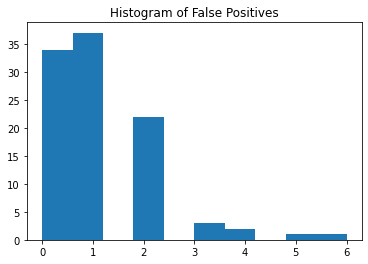

In [17]:
fig1 = plt.hist(fp)
plt.title(r'Histogram of False Positives')

Text(0.5, 1.0, 'Histogram of False Positives after Bootstrap')

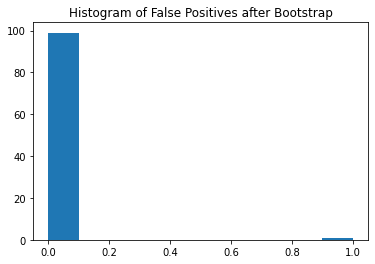

In [18]:
fig2 = plt.hist(mb_fp)
plt.title(r'Histogram of False Positives after Bootstrap')